<h1>Gleichstrommaschine im Zustandsraum</h1>

<p>In diesem Notebook werden verschiedene Aspekte des Entwurfs der Steuerung einer Gleichstrommaschine im Zustandsraum vorgestellt.
Die Analyse wird zunächst ohne externe Störung durchgeführt und dann wird ein Widerstandsmoment hinzugefügt.
Zunächst stellen wir das Modell der Gleichstrommaschine vor.</p>


In [41]:
clear all
pkg load control

% Winding resistance
R = 1;

% Winding inductance
L = 0.01;

% EMF Constant
Vn = 300
Wn = 500
K = Vn/Wn

% Mechanincal Inertia
J = 0.001

%Mechanical losses
Km = 0.001


Vn =  300
Wn =  500
K =  0.60000
J =  0.0010000
Km =  0.0010000


<p>Dann bilden wir die Zustandsraumdarstellung mit Strom und Geschwindigkeit als Zustandsvariablen.</p>



In [42]:
% Set the Octsim Engine to run the simulation
addpath('../Octsim');

A = [-R/L -K/L; K/J -Km/J]
B = [1/L; 0]
C = [1 0; 0 1]
D = [0; 0]


A =

  -100   -60
   600    -1

B =

   100
     0

C =

   1   0
   0   1

D =

   0
   0



<h2>Zeitkontinuierlicher Entwurf</h2>
<p>Als ersten Schritt müssen wir die Steuerbarkeit des Systems überprüfen.<br>
Zu diesem Zweck ist es wichtig, dass der Rang der Steuerbarkeitsmatrix gleich der Ordnung des Systems ist.</p>

In [43]:
Sc = [B A*B]
rank(Sc)

Sc =

     100  -10000
       0   60000

ans =  2


<p>Eine weitere wichtige Information ist die Auswertung der Eigenwerte im offenen Regelkreis:</p>

In [44]:
eigs(A)

ans =

   -50.50 + 183.17i
   -50.50 - 183.17i



Lassen Sie uns zunächst einige Spezifikationen definieren.

In [45]:
% Raise time
Ts = 5e-3

% Overshoot
M = 0.1

om = pi/(2*Ts)
alfa = (log(M)/pi)^2
csi= sqrt(alfa/(1+alfa))

p1 = -csi*om+1j*om*sqrt(1-csi*csi)
p2 = -csi*om-1j*om*sqrt(1-csi*csi)

Ts =  0.0050000
M =  0.10000
om =  314.16
alfa =  0.53719
csi =  0.59116
p1 = -185.72 + 253.39i
p2 = -185.72 - 253.39i


<p>Um den Regelkreis zu schließen, geben wir die Polposition an und berechnen die Verstärkung der Rückkopplung</p>

In [46]:
pt = [p1 p2];
Kf = place(A,B,pt)

Kf =

   2.7043   1.0388



<p>Die Simulation kann zur Überprüfung des Systemverhaltens verwendet werden.<br>
Zunächst simulieren wir die freie Entwicklung des Systems im offenen Kreislauf.</p>

<img src="figures/DCOpenLoop.svg" alt="drawing" width="600"  height="300"/>

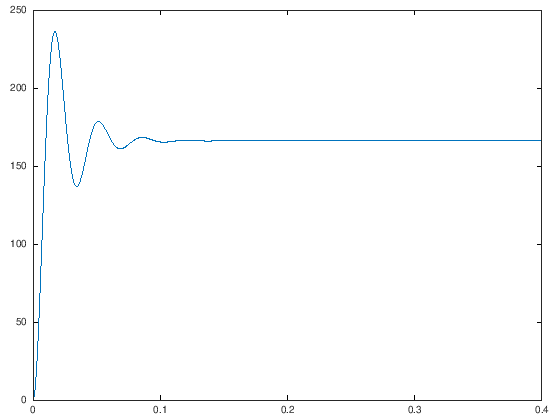

In [47]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 0.4;
% Time Step
dt = 0.00005;
% Number of data flows in the schematic
nflows = 3;


xo = [0; 0];

% Instance of the simulation schematic
sc1 = Schema(tini,tfinal,dt,nflows);

% List of components
c1{1} = Constant(1,100);
c1{2} = StateSpace(1,[2, 3],A,B,C,D,xo);

sc1.AddListComponents(c1);

% Run the schematic and plot
out1 = sc1.Run([1,3]);
plot(out1(1,:),out1(3,:));

<p>Die vorherige Simulation wurde im offenen Regelkreis durchgeführt.<br>
Ein weiterer Aspekt ist die Untersuchung von Systemen, für die wir einen bestimmten Sollwert festlegen wollen.<br>
Zunächst muss die Verstärkung der Referenz neu skaliert werden, um die Gesamtverstärkung zu vereinheitlichen.</p>

In [48]:
% We assume the speed as variable of interest
C3 = [0 1];
V = inv(C3*inv(B*Kf-A)*B)

V =  1.6449


<p>Die nächste Simulation analysiert das Verhalten des geschlossenen Regelkreises bei einem Sprung zum Sollwert.<br>
Wir erwarten dann einen modifizierten stationären Zustand, der dem Schrittwert des Eingangs entsprich.</p>

<img src="figures/DCClosedLoop.svg" alt="drawing" width="600"  height="300"/>

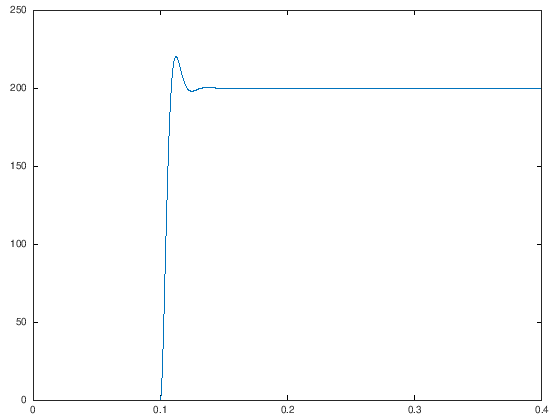

In [49]:
% Number of data flows in the schematic
nflows2 = 6;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows2);

% List of components
c3{1} = StepSource(1,0,200,0.1);
c3{2} = Gain(1,2,V);
c3{3} = Sum(2,3,4,1,-1); 
c3{4} = StateSpace(4,[5 6],A,B,C,D,xo);
c3{5} = Gain([5 6],3,Kf);

sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([6 4]);
plot(out3(1,:),out3(2,:));

<p>Das System erreicht korrekt den Referenzwert<br>
   Ein weiterer Aspekt ist auch die Analyse der Leistung des Eingangskanals (Spannung):
</p>

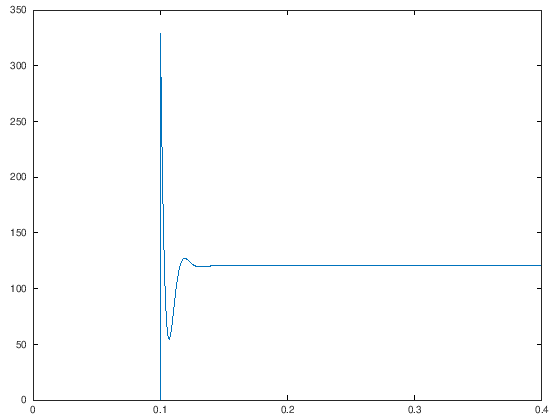

In [50]:
plot(out3(1,:),out3(3,:));

<p>Fügen wir nun eine Störung hinzu, d.h. ein Widerstandsmoment, so ergibt sich:</p>

B2 =

    100      0
      0  -1000

D2 =

   0   0
   0   0



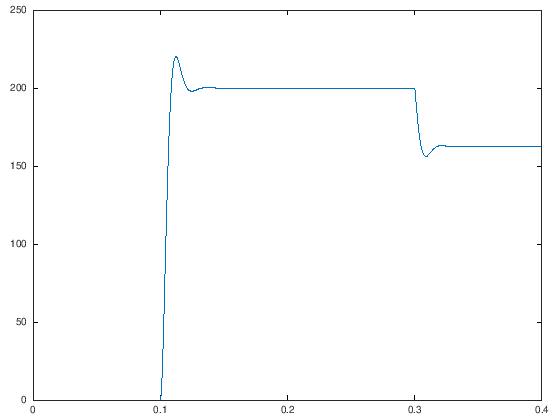

In [52]:
% Number of data flows in the schematic
nflows3 = 7;

% Instance of the simulation schematic
sc4 = Schema(tini,tfinal,dt,nflows3);

% Adding as input the resistive torque
B2 = [1/L 0; 0 -1/J]
D2 = [0 0; 0 0]

% List of components
c4{1} = StepSource(1,0,200,0.1);
c4{2} = Gain(1,2,V);
c4{3} = Sum(2,3,4,1,1);
c4{4} = StepSource(7,0,10,0.3);
c4{5} = StateSpace([4 7],[5 6],A,B2,C,D2,xo);
c4{6} = Gain([5 6],3,-Kf);

sc4.AddListComponents(c4);

% Run the schematic and plot
out4 = sc4.Run([6]);
plot(out4(1,:),out4(2,:));

<p>Die Steuerung kann die Störung nicht kompensieren. Wir müssen eine Integrationsmaßnahme hinzufügen.<br>
Aus diesem Grund benötigen wir eine neue Zustandsvariable und müssen den Entwurf erneut durchführen.<br>
Wir beginnen mit der Definition des neuen Systems:</p>

In [53]:
Ae = [-R/L -K/L 0; K/J -Km/J 0; 0 1 0]
Be = [1/L; 0; 0]

Ae =

  -100   -60     0
   600    -1     0
     0     1     0

Be =

   100
     0
     0



<p>Wir müssen die Steuerbarkeit erneut überprüfen:</p>

In [54]:
Sce = [Be Ae*Be Ae*Ae*Be]
rank(Sce)

Sce =

       100    -10000  -2600000
         0     60000  -6060000
         0         0     60000

ans =  3


<p>Wir wiederholen dann den Entwurf für das neue System und einen weiteren Pol in der Spezifikation.</p>

In [55]:
p3 = -1000
pte = [p1 p2 p3];
Kfe = acker(Ae,Be,pte)

p3 = -1000
Kfe =

     12.7043      7.2127   1644.9341



<p>Nun wiederholen wir die Simulation im geschlossenen Regelkreis mit dem Integrator.</p>

<img src="figures/DCClosedLoopIntegral.svg" alt="drawing" width="600"  height="300"/>

B2 =

    100      0
      0  -1000

D2 =

   0   0
   0   0



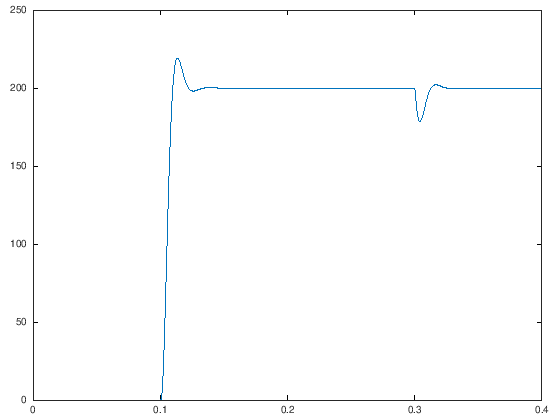

In [56]:
% Number of data flows in the schematic
nflows4 = 10;

% Instance of the simulation schematic
sc5 = Schema(tini,tfinal,dt,nflows4);

% Adding as input the resistive torque
B2 = [1/L 0; 0 -1/J]
D2 = [0 0; 0 0]

% List of components
c5{1} = StepSource(1,0,200,0.1);
c5{2} = Sum(1,9,2,-1,1);
c5{3} = Integrator(2,3,0);
c5{4} = Gain(3,5,-Kfe(3));
c5{5} = Sum(10,5,7,1,1);
c5{6} = StepSource(6,0,10,0.3);
c5{7} = StateSpace([7 6],[8 9],A,B2,C,D2,xo);
c5{8} = Gain([8 9],10,[-Kfe(1) -Kfe(2)]);

sc5.AddListComponents(c5);

% Run the schematic and plot
out5 = sc5.Run([9]);
plot(out5(1,:),out5(2,:));

<p>Die Simulationsergebnisse bestätigen die theoretischen Annahmen.</p>

<h2>Regler mit Beobachter</h2>

<p>Wir gehen nun davon aus, dass nur die Geschwindigkeit gemessen wird.
Dann ist es notwendig, einen Beobachter hinzuzufügen, und wir müssen die Beobachtbarkeit überprüfen.</p>

In [57]:
Cm = [0 1]

So = [Cm; Cm*A]

det(So)

Cm =

   0   1

So =

     0     1
   600    -1

ans = -600


Wir definieren die Beobachterpole und berechnen dann die Beobachterverstärkung.

In [58]:
pobs = [-500 -1000]

G = place(A',Cm',pobs)

pobs =

   -500  -1000

G =

    540.00   1399.00



Schließlich testen wir das Gesamtsystem per Simulation.

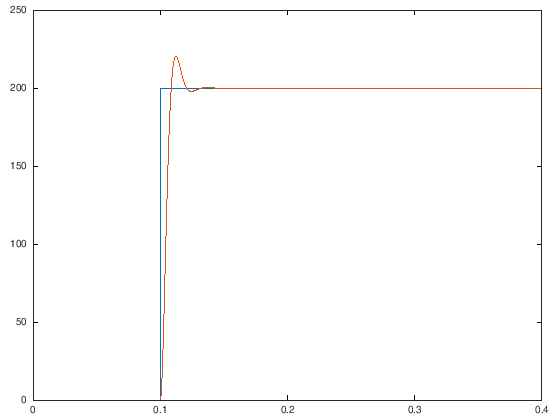

In [63]:
% Number of data flows in the schematic
nflows6 = 7;

% Instance of the simulation schematic
sc6 = Schema(tini,tfinal,dt,nflows6);

xb = [0; 0];

% List of components
c6{1} = StepSource(1,0,200,0.1);
c6{2} = Gain(1,2,V);
c6{3} = Sum(2,3,4,1,-1); 
c6{4} = StateSpace(4,5,A,B,Cm,D,xo);
c6{5} = StateSpace([4 5],[6 7],A-G'*Cm,[B G'],eye(2),zeros(2,2),xb);
c6{6} = Gain([6 7],3,Kf);

sc6.AddListComponents(c6);

% Run the schematic and plot
out6 = sc6.Run([1 5]);
plot(out6(1,:),out6(2,:),out6(1,:),out6(3,:));